<a href="https://colab.research.google.com/github/rikoder/IITB_Research_Work/blob/main/Hyperspectral_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'tomato'>Hyperspectral Image Analysis - Classification</font>

## Import Libraries

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import jaccard_score, accuracy_score, f1_score, cohen_kappa_score
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

## Download HSI Data

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat # Pavia University
!wget https://www.ehu.eus/ccwintco/uploads/e/e3/Pavia.mat https://www.ehu.eus/ccwintco/uploads/5/53/Pavia_gt.mat # Pavia center
!wget https://www.ehu.eus/ccwintco/uploads/1/1a/SalinasA_corrected.mat https://www.ehu.eus/ccwintco/uploads/a/aa/SalinasA_gt.mat #SalinasA
# !wget https://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat https://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat #Salinas

## Read the Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/SalinasA_Normalized.csv')

In [ ]:
from scipy.io import loadmat

def ReadData(matFileName='PaviaU', matData = "paviaU"):
  def read_HSI():
    # X = loadmat(matFileName+'.mat')[matData]
    # y = loadmat(matFileName + '_gt.mat')[matData + '_gt']

    X = loadmat('SalinasA_corrected.mat')['salinasA_corrected']
    y = loadmat('SalinasA_gt.mat')['salinasA_gt']

    # print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return X, y

  X, y = read_HSI()
  return X,y


## Convert the dataset into csv

In [ ]:
def ConvertDatasetIntoCSV(X,y):
  def extract_pixels(X, y):
    q = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(data = q)
    df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
    df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
    df.to_csv('RawDataset.csv')
    return df

  df = extract_pixels(X, y)
  return df

## Normalization Functions

In [ ]:
# def bandmax_normalize(df):
#     df_normalized = df.apply(lambda x: x / x.max())
#     return df_normalized
def bandmax_normalize(df): #Last column left unnormalized
    df_normalized = df.iloc[:, :-1].apply(lambda x: x / x.max())
    df_normalized = pd.concat([df_normalized, df.iloc[:, -1]], axis=1)
    return df_normalized


def band_min_max(df): #Last column left unnormalize
    num_cols = df.shape[1]
    max_values = np.max(df.iloc[:, :-1], axis=0)
    min_values = np.min(df.iloc[:, :-1], axis=0)
    normalized = (df.iloc[:, :-1] - min_values[np.newaxis, :])/(max_values[np.newaxis, :] - min_values[np.newaxis, :])
    normalized = pd.concat([pd.DataFrame(normalized), df.iloc[:, -1]], axis=1)
    return normalized

def Max(df): #Last column left unnormalized
    max_value = df.iloc[:, :-1].max().max()
    normalized_df = df.iloc[:, :-1] / max_value
    normalized_df = pd.concat([normalized_df, df.iloc[:, -1]], axis=1)
    return normalized_df

def MinMax(df): #Last column left unnormalized
    max_value = df.iloc[:, :-1].max().max()
    min_value = df.iloc[:, :-1].min().min()
    normalized_df = (df.iloc[:, :-1] - min_value) / (max_value - min_value)
    normalized_df = pd.concat([normalized_df, df.iloc[:, -1]], axis=1)
    return normalized_df

def gaussian_normalization(df): #Last column left unnormalized
    df_normalized = df.iloc[:, :-1].apply(lambda x: (x - np.mean(x)) / np.std(x))
    df_normalized = pd.concat([df_normalized, df.iloc[:, -1]], axis=1)
    return df_normalized

def norm2_normalization(df): #Last column left unnormalized
    df_normalized = df.iloc[:, :-1].apply(lambda x: x / np.linalg.norm(x))
    df_normalized = pd.concat([df_normalized, df.iloc[:, -1]], axis=1)
    return df_normalized

def sklearn_normalization(df):
    scaler = MinMaxScaler()
    df_normalized = df.iloc[:, :-1].copy()
    df_normalized.loc[:, df_normalized.columns] = scaler.fit_transform(df_normalized[df_normalized.columns])
    df_normalized = pd.concat([df_normalized, df.iloc[:, -1]], axis=1)
    return df_normalized

def normalizeData(df, normalization):
  if(normalization == "sklearn"):
    aedf = sklearn_normalization(df)
    print("sklearn normalization")
  elif(normalization == "BandMax"):
    aedf = bandmax_normalize(df)
    print("BandMax normalization")
  elif(normalization == "band_min_max"):
    aedf = band_min_max(df)
    print("band_min_max normalization")
  elif(normalization == "norm2_normalization"):
    aedf = norm2_normalization(df)
    print("norm2_normalization normalization")
  elif(normalization == "Max"):
    aedf = Max(df)
    print("Max normalization")
  elif(normalization == "MinMax"):
    aedf = MinMax(df)
    print("MinMax normalization")
  elif(normalization == "gaussian_normalization"):
    aedf = gaussian_normalization(df)
    print("gaussian_normalization normalization")
  else:
    aedf = df
    print("No normalization")
  return aedf


## GPU Availability check


In [ ]:
# Check if a GPU is available and set it as the default device

if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("GPU being used")
else:
    device = '/CPU:0'
    print("CPU being used")



CPU being used


##AutoEncoder (AE) Dimensionality Reduction training

In [ ]:
def AE_Shallow_Training(train_data, test_data, epochs=50, encoding_dim = 20, dae=False):
  # aedf = df.values
  # aedf_X = aedf[:,:-1]
  # aedf_y = aedf[:,-1]
  # print("Overal Train Data shape: ", aedf.shape)

  # train_data = aedf_X[:20000,:]
  # valid_data = aedf_X[20000:,:]
  print("train shape: ", train_data.shape)
  print("test Data shape: ", test_data.shape)

  # Define the autoencoder model
  input_dim = train_data.shape[1]
  encoding_dim = encoding_dim
  with tf.device(device):
      autoencoder = keras.Sequential([
          layers.Dense(128, activation='relu', input_shape=(input_dim,)),
          layers.Dense(64, activation='relu'),
          layers.Dense(encoding_dim, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(input_dim, activation='sigmoid')
      ])

  # Compile the autoencoder model
  adam = optimizers.Adam(lr=0.001)
  with tf.device(device):
      autoencoder.compile(optimizer='adam', loss='mse')

  # Train the autoencoder model
  with tf.device(device):
      autoencoder.fit(train_data, train_data,
                      epochs=epochs,
                      batch_size=256,
                      shuffle=True)
  encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
  encoder.save("SalinasA_AE100_Model")

  with tf.device(device):
    # autoencoder.eval()
    encoded_data = encoder.predict(train_data)
    x_train_reconstructed = autoencoder.predict(train_data)#autoencoder.predict(aedf)
    train_reconstruction_error = np.mean(np.square(train_data - x_train_reconstructed))

    encoded_test_data = encoder.predict(test_data)
    x_test_reconstructed = autoencoder.predict(test_data)
    test_reconstruction_error = np.mean(np.square(test_data - x_test_reconstructed))

    # print(f'Train reconstruction error: {train_reconstruction_error:.4f}')
    # print(f'Test reconstruction error: {test_reconstruction_error:.4f}')
  # encoded_data
  # print("dt shape is: ", dt.shape)
  # q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = aedf_y.ravel())], axis = 1)
  # q.columns = [f'PC-{i}' for i in range(1,41)]+['class']
  # print("q shape is: ", q.shape)
  # print(q['class'])
  return encoded_data, encoded_test_data

In [ ]:
def AE_Deep_Training(df, normalization):
  aedf = df.values
  aedf_X = aedf[:,:-1]
  aedf_y = aedf[:,-1]
  train_data = aedf_X[:165920,:]
  valid_data = aedf_X[165920:,:]

  # Define the autoencoder model
  input_dim = aedf_X.shape[1]
  encoding_dim = 40
  with tf.device(device):
      autoencoder = keras.Sequential([
          layers.Dense(128, activation='relu', input_shape=(input_dim,)),
          layers.Dense(64, activation='relu'),
          layers.Dense(encoding_dim, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(input_dim, activation='sigmoid')
      ])

  # Compile the autoencoder model
  adam = optimizers.Adam(lr=0.01)
  with tf.device(device):
      autoencoder.compile(optimizer='adam', loss='mse')

  # Train the autoencoder model
  with tf.device(device):
      autoencoder.fit(train_data, train_data,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(valid_data, valid_data))
  encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
  with tf.device(device):
    encoded_data = encoder.predict(aedf_X)
    x_train_reconstructed = autoencoder.predict(train_data)#autoencoder.predict(aedf)
    train_reconstruction_error = np.mean(np.square(train_data - x_train_reconstructed))

    x_test_reconstructed = autoencoder.predict(valid_data)
    test_reconstruction_error = np.mean(np.square(valid_data - x_test_reconstructed))

    print(f'Train reconstruction error: {train_reconstruction_error:.4f}')
    print(f'Test reconstruction error: {test_reconstruction_error:.4f}')
  dt = encoded_data
  print("dt shape is: ", dt.shape)
  q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = aedf_y.ravel())], axis = 1)
  q.columns = [f'PC-{i}' for i in range(1,41)]+['class']
  print("q shape is: ", q.shape)
  print(q['class'])
  return q

## Principal Component Analysis(PCA)


In [ ]:
def code_PCA(global_x_train, global_x_test, n_components=20):
  # pca_df = global_x_train
  # pca = PCA(n_components = 85)
  # with tf.device(device):
  #   principalComponents = pca.fit_transform(pca_df.iloc[:, :-1].values)

  #   ev=pca.explained_variance_ratio_

    # plt.figure(figsize=(12, 6))
    # plt.plot(np.cumsum(ev))
    # plt.xlabel('Number of components')
    # plt.ylabel('Cumulative explained variance')


    # plt.show()

  pca = PCA(n_components = n_components)
  encoded_train = pca.fit_transform(global_x_train)
  encoded_test = pca.fit_transform(global_x_test)
  #q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
  #q.columns = [f'PC-{i}' for i in range(1,41)]+['class']

  return encoded_train, encoded_test

## Linear Discriminant Analysis(LDA)





In [ ]:
def LDA(df, normalization):
  lda_df = df
  ndf = df

  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

  lda = LinearDiscriminantAnalysis()
  dt = lda.fit_transform(lda_df.iloc[:, :-1], ndf.iloc[:, -1])


  # lda = LinearDiscriminantAnalysis()
  # dt = lda.fit_transform(lda_df.iloc[:, :-1].values,lda_df.iloc[:, -1].values)
  # print("dt shape is: ", dt.shape)
  #q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
  #q.columns = [f'PC-{i}' for i in range(1,10)]+['class']
  # print("q shape is: ", q.shape)
  return q



## Support Vector Machine(SVM)


In [ ]:
# names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil']#, 'Bitumen', 'Self-Blocking Bricks', 'Shadows','10','11','12','13','14','15','16']

def evaluation(y_test, ypred):
    ## Confusion matrix printing from here
  data = confusion_matrix(y_test, ypred)
  print("Confusion Matrix: ")
  print(data)
  df_cm = pd.DataFrame(data, columns=names, index = names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10,8))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
  plt.show()
  plt.savefig('cmap.png', dpi=300)
  ## Till here.
  IoU_pca_accuracy = jaccard_score(y_test, ypred, average= "micro")
  Overall_pca_accuracy = accuracy_score(y_test, ypred)
  print(IoU_pca_accuracy)
  print(classification_report(y_test, ypred, target_names = names))


def SVM(X, y, c=1.0):
  # q = q[q['class'] != 0]
  # x=q
  # X = x.iloc[:, :-1].values
  # y = x.loc[:, 'class'].values

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
  svm =  SVC(C = c, kernel = 'rbf', cache_size = 1024)
  with tf.device(device):
    svm.fit(X, y)
    print("svm.fit has ran")
    #ypred = svm.predict(X_test)
  return svm#, X_train, X_test, y_train, y_test


## Function to Save the results/scores

In [ ]:
def save_results(filenameclasswisescores, filenameconfusionmatrix, y_test, ypred):
  names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
  #Saving classwise scores
  classwise_scores = classification_report(y_test, ypred, target_names = names, output_dict = True)
  df = pd.DataFrame(classwise_scores)
  df.to_csv(filenameclasswisescores+".csv")
  # Saving confusion matrix
  data = confusion_matrix(y_test, ypred)
  np.savetxt(filenameconfusionmatrix+".csv",data, delimiter = ",", fmt='%d')


## Data corruption function


In [ ]:
def Corrupt_Data(labels, percentage=0.3):
    # Make a copy of the labels
    labels_copy = labels.copy()

    classes = np.unique(labels_copy)
    num_elements = int(percentage * len(labels_copy))
    indices = np.random.choice(len(labels_copy), size=num_elements, replace=False)
    random_values = np.random.choice(classes, size=num_elements)

    # Update the selected elements in the labels_copy array
    labels_copy[indices] = random_values

    return labels_copy


## Automate Function

In [ ]:
X,y = ReadData()
df = ConvertDatasetIntoCSV(X,y)
df = normalizeData(df, "band_min_max")
df.to_csv("Pavia_Center_Normalized.csv")

<ipython-input-6-d09062830d09>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized = (df.iloc[:, :-1] - min_values[np.newaxis, :])/(max_values[np.newaxis, :] - min_values[np.newaxis, :])


band_min_max normalization


In [ ]:
df = data

In [ ]:
df

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,0.180875,0.139125,0.121625,0.131625,0.147500,0.157875,0.160625,0.165000,0.160375,0.161875,...,0.223500,0.218625,0.197454,0.198880,0.199236,0.198219,0.207500,0.191838,0.201250,0
1,0.150375,0.163000,0.175250,0.190625,0.198250,0.195000,0.182625,0.178750,0.179250,0.181625,...,0.137875,0.137000,0.123234,0.129615,0.129554,0.123282,0.134375,0.126112,0.147750,0
2,0.197375,0.187250,0.162375,0.151000,0.156375,0.160250,0.161375,0.157125,0.152625,0.147875,...,0.139500,0.137500,0.123616,0.124268,0.125860,0.127990,0.142125,0.128528,0.145125,0
3,0.070250,0.106250,0.127500,0.134375,0.126000,0.114250,0.124000,0.124750,0.116125,0.116250,...,0.265250,0.264000,0.254488,0.254138,0.249554,0.253817,0.267375,0.253750,0.265250,0
4,0.148500,0.146750,0.148625,0.172875,0.181375,0.179125,0.181500,0.185750,0.189750,0.190000,...,0.218625,0.216000,0.195799,0.191622,0.187261,0.183461,0.194500,0.183066,0.202500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42771,0.113875,0.129750,0.128250,0.109875,0.099750,0.111125,0.113000,0.098000,0.104875,0.115125,...,0.329000,0.330000,0.319032,0.318054,0.315796,0.317048,0.328625,0.317951,0.329250,1
42772,0.120250,0.095500,0.100250,0.107750,0.111750,0.118875,0.116750,0.110375,0.107250,0.099875,...,0.338125,0.339000,0.328071,0.323657,0.317707,0.316539,0.328625,0.316934,0.335125,1
42773,0.094750,0.054875,0.061125,0.086750,0.101500,0.098625,0.091625,0.094125,0.102750,0.107750,...,0.349875,0.352250,0.341566,0.337917,0.329554,0.332443,0.343875,0.330536,0.340000,1
42774,0.125000,0.092625,0.100250,0.110875,0.118250,0.119750,0.108750,0.104375,0.109000,0.106500,...,0.373500,0.375750,0.364481,0.354342,0.343185,0.343003,0.358750,0.351004,0.362375,1


In [ ]:
df = data
df = df[df['class'] != 0]
df['class'] = df['class']-1
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]

## Labels corruption
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
corrupted_y_train = Corrupt_Data(global_y_train, percentage = 0.3)


<ipython-input-46-b8060455b68e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class']-1


In [ ]:
arr = global_y_train == corrupted_y_train

In [ ]:
df = data
# Assuming 'df' is your DataFrame and 'target_column' is the name of the column containing your target variable
target_column = 'class'  # Replace with the actual name of your target column

# Calculate the counts of each class in the target variable
class_counts = df[target_column].value_counts()

# Identify classes with only one instance
single_instance_classes = class_counts[class_counts < 3].index

# Remove rows corresponding to those classes
df = df[~df[target_column].isin(single_instance_classes)]


In [ ]:
df

,Unnamed: 0,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,band196,band197,band198,band199,band200,band201,band202,band203,band204,class
305,305,0.387895,0.437442,0.380874,0.344271,0.330699,0.318848,0.310673,0.299493,0.298264,...,0.207843,0.203279,0.190566,0.104825,0.123563,0.086551,0.050388,0.016561,0.031807,5
306,306,0.486933,0.359592,0.380874,0.332892,0.319044,0.318848,0.307085,0.297036,0.292521,...,0.215686,0.193443,0.198113,0.114809,0.129310,0.081225,0.052972,0.024204,0.045802,5
307,307,0.486933,0.437442,0.380874,0.332892,0.319044,0.314865,0.303677,0.297036,0.294479,...,0.211765,0.193443,0.194340,0.108153,0.123563,0.091877,0.045220,0.024204,0.034351,5
308,308,0.486933,0.437442,0.380874,0.332892,0.324773,0.314865,0.307085,0.299493,0.300091,...,0.196078,0.196721,0.209434,0.101498,0.126437,0.075899,0.052972,0.019108,0.029262,5
309,309,0.486933,0.359592,0.380874,0.332892,0.324773,0.323013,0.317489,0.309630,0.305835,...,0.211765,0.190164,0.190566,0.098170,0.120690,0.081225,0.045220,0.021656,0.034351,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110689,110689,0.291609,0.367933,0.245902,0.220958,0.202489,0.191381,0.175605,0.160958,0.152199,...,0.068627,0.063934,0.081132,0.038270,0.041667,0.030626,0.023256,0.015287,0.033079,15
110690,110690,0.291609,0.213160,0.245902,0.209844,0.202489,0.187217,0.175605,0.160958,0.152199,...,0.068627,0.060656,0.062264,0.034942,0.038793,0.027963,0.020672,0.025478,0.016539,15
110691,110691,0.291609,0.135310,0.209836,0.198465,0.202489,0.187217,0.168610,0.158347,0.150372,...,0.052941,0.045902,0.052830,0.028286,0.025862,0.022636,0.023256,0.010191,0.021628,15
110692,110692,0.291609,0.213160,0.245902,0.198465,0.196760,0.187217,0.172197,0.158347,0.152199,...,0.060784,0.049180,0.062264,0.031614,0.044540,0.030626,0.018088,0.012739,0.019084,15


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Copy of PUnormalisedData.csv')

In [ ]:
data

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,0.180875,0.139125,0.121625,0.131625,0.147500,0.157875,0.160625,0.165000,0.160375,0.161875,...,0.223500,0.218625,0.197454,0.198880,0.199236,0.198219,0.207500,0.191838,0.201250,0
1,0.150375,0.163000,0.175250,0.190625,0.198250,0.195000,0.182625,0.178750,0.179250,0.181625,...,0.137875,0.137000,0.123234,0.129615,0.129554,0.123282,0.134375,0.126112,0.147750,0
2,0.197375,0.187250,0.162375,0.151000,0.156375,0.160250,0.161375,0.157125,0.152625,0.147875,...,0.139500,0.137500,0.123616,0.124268,0.125860,0.127990,0.142125,0.128528,0.145125,0
3,0.070250,0.106250,0.127500,0.134375,0.126000,0.114250,0.124000,0.124750,0.116125,0.116250,...,0.265250,0.264000,0.254488,0.254138,0.249554,0.253817,0.267375,0.253750,0.265250,0
4,0.148500,0.146750,0.148625,0.172875,0.181375,0.179125,0.181500,0.185750,0.189750,0.190000,...,0.218625,0.216000,0.195799,0.191622,0.187261,0.183461,0.194500,0.183066,0.202500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42771,0.113875,0.129750,0.128250,0.109875,0.099750,0.111125,0.113000,0.098000,0.104875,0.115125,...,0.329000,0.330000,0.319032,0.318054,0.315796,0.317048,0.328625,0.317951,0.329250,1
42772,0.120250,0.095500,0.100250,0.107750,0.111750,0.118875,0.116750,0.110375,0.107250,0.099875,...,0.338125,0.339000,0.328071,0.323657,0.317707,0.316539,0.328625,0.316934,0.335125,1
42773,0.094750,0.054875,0.061125,0.086750,0.101500,0.098625,0.091625,0.094125,0.102750,0.107750,...,0.349875,0.352250,0.341566,0.337917,0.329554,0.332443,0.343875,0.330536,0.340000,1
42774,0.125000,0.092625,0.100250,0.110875,0.118250,0.119750,0.108750,0.104375,0.109000,0.106500,...,0.373500,0.375750,0.364481,0.354342,0.343185,0.343003,0.358750,0.351004,0.362375,1


In [ ]:
datasetName = 'Pavia'
matData = "pavia"
# X,y = ReadData(matFileName=datasetName, matData = matData)
# df = ConvertDatasetIntoCSV(X,y)
# df = normalizeData(df, "band_min_max")
df = data

## ONLY FOR SALINASA
# df = df.drop(df.columns[0], axis=1)

##Only for PS Normalized
# df = df.drop(df.columns[-1], axis=1)

df = df[df['class'] != 0]
df['class'] = df['class']-1
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]

## Labels corruption
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
corrupted_y_train = Corrupt_Data(global_y_train, percentage = 0.3)
global_y_train = corrupted_y_train


encoded_train, encoded_test = AE_Shallow_Training(global_x_train, global_x_test, epochs = 100, encoding_dim = 20)
# encoded_train, encoded_test = code_PCA(global_x_train, global_x_test, n_components=10)
# encoded_train, encoded_test = global_x_train, global_x_test

# svm = SVM(encoded_train, global_y_train, c= 1)
# ypred = svm.predict(encoded_test)

model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
model.fit(encoded_train, global_y_train)
ypred = model.predict(encoded_test)


# Recording experiment results
names = [i for i in range(8)]
y_test = global_y_test
overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']
weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']
Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")
Kappa_Score = cohen_kappa_score(y_test, ypred)

new_row = {'Hidden nodes': 20,
          'Overall F1 score': overall_f1_score,
          'Weighted average F1 Score': weighted_avg_f1_score,
          'IoU/Jaccard Score': Jaccard_Score,
          'Kappa': Kappa_Score}

new_row



<ipython-input-21-3bfbd4884e9f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class']-1


train shape:  (28916, 103)
test Data shape:  (7229, 103)
Epoch 1/100
113/113 [==============================] - 2s 6ms/step - loss: 0.0277
Epoch 2/100
113/113 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 3/100
113/113 [==============================] - 1s 7ms/step - loss: 2.7553e-04
Epoch 4/100
113/113 [==============================] - 1s 6ms/step - loss: 1.2389e-04
Epoch 5/100
113/113 [==============================] - 1s 10ms/step - loss: 9.4004e-05
Epoch 6/100
113/113 [==============================] - 1s 9ms/step - loss: 8.5907e-05
Epoch 7/100
113/113 [==============================] - 1s 10ms/step - loss: 8.0219e-05
Epoch 8/100
113/113 [==============================] - 1s 10ms/step - loss: 7.8654e-05
Epoch 9/100
113/113 [==============================] - 1s 7ms/step - loss: 7.5514e-05
Epoch 10/100
113/113 [==============================] - 1s 6ms/step - loss: 7.5221e-05
Epoch 11/100
113/113 [==============================] - 1s 6ms/step - loss: 7.2202e-05


226/226 [==============================] - 0s 1ms/step


{'Hidden nodes': 20,
 'Overall F1 score': 0.856550006916586,
 'Weighted average F1 Score': 0.8512675481256546,
 'IoU/Jaccard Score': 0.7490926687636099,
 'Kappa': 0.7875836418101844}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
datasetName = 'SalinasA'
matData = "paviaU"
X,y = ReadData(matFileName=datasetName, matData = matData)
print("Original Data: ", X.shape)
df = ConvertDatasetIntoCSV(X,y)
print("Csv converted data: ", df.shape)
df = normalizeData(df, "band_min_max")
print("Normalized Data: ", df.shape)
df = df[df['class'] != 0]
df['class'] = df['class']-1
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
# encoded_train, encoded_test = code_PCA(global_x_train, global_x_test, n_components=10)
encoded_train, encoded_test = AE_Shallow_Training(global_x_train, global_x_test, epochs = 100, encoding_dim = 20)

# df_encoded_train = pd.DataFrame(encoded_train)
# df_encoded_train['label'] = global_y_train
# df_encoded_train.to_csv(datasetName+ '_AE_100_encoded_train.csv', index=False)

percentages = [0.10, 0.25, 0.50, 0.75, 100.00]
Limited_Size_Experiments = pd.DataFrame(columns=["Dataset Name", "Train size percentage", "Overall F1 score", "Weighted average F1 Score", "IoU/Jaccard Score", "Kappa"])

for i in percentages:
  print("Train size percentage: ", i)
  if i!=100.00:
    lim_x_train, lim_x_test, lim_y_train, lim_y_test = train_test_split(encoded_train, global_y_train, test_size= 1 - i, random_state=20, stratify=global_y_train, shuffle=True)
    # svm = SVM(lim_x_train, lim_y_train, c= 1) # limited percentage of global train
    model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    model.fit(lim_x_train, lim_y_train)
  else:
    # svm = SVM(encoded_train, global_y_train, c= 1)
    model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    model.fit(encoded_train, global_y_train)

  ypred = model.predict(encoded_test)
  names = [str(i) for i in range(6)]
  y_test = global_y_test
  overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']*100
  weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']*100
  Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")*100
  Kappa_Score = cohen_kappa_score(y_test, ypred)*100

  new_row = {'Dataset Name':datasetName,
            'Train size percentage': i,
           'Overall F1 score': overall_f1_score,
           'Weighted average F1 Score': weighted_avg_f1_score,
           'IoU/Jaccard Score': Jaccard_Score,
           'Kappa': Kappa_Score}

  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)
Limited_Size_Experiments.to_csv("SalinasA_AE_RF.csv")
from google.colab import files
files.download('SalinasA_AE_RF.csv')

In [ ]:
datasetName = 'PaviaU'
matData = "paviaU"
X,y = ReadData(matFileName=datasetName, matData = matData)
print("Original Data: ", X.shape)
df = ConvertDatasetIntoCSV(X,y)
print("Csv converted data: ", df.shape)
df = normalizeData(df, "band_min_max")
print("Normalized Data: ", df.shape)
df = df[df['class'] != 0]
df['class'] = df['class']-1
# print(df['class'].nunique())
# #df.to_csv("normalisedData.csv")
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
encoded_train, encoded_test = code_PCA(global_x_train, global_x_test, n_components=10)
#encoded_train, encoded_test = AE_Shallow_Training(global_x_train, global_x_test, epochs = 50, encoding_dim = 20)
# print("After DR: ", q.shape)
#q_norm = normalizeData(q, "sklearn")
# svm = SVM(encoded_train, global_y_train, c= 1) # 100% of global train
percentages = [0.10, 0.25, 0.50, 0.75, 100.00]
Limited_Size_Experiments = pd.DataFrame(columns=["Dataset Name", "Train size percentage", "Overall F1 score", "Weighted average F1 Score", "IoU/Jaccard Score", "Kappa"])

for i in percentages:
  print("Train size percentage: ", i)
  if i!=100.00:
    lim_x_train, lim_x_test, lim_y_train, lim_y_test = train_test_split(encoded_train, global_y_train, test_size= 1 - i, random_state=20, stratify=global_y_train, shuffle=True)
    svm = SVM(lim_x_train, lim_y_train, c= 1) # limited percentage of global train
  else:
    svm = SVM(encoded_train, global_y_train, c= 1)

  ypred = svm.predict(encoded_test)

  y_test = global_y_test
  overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']*100
  weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']*100
  Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")*100
  Kappa_Score = cohen_kappa_score(y_test, ypred)*100

  new_row = {'Dataset Name':datasetName,
            'Train size percentage': i,
           'Overall F1 score': overall_f1_score,
           'Weighted average F1 Score': weighted_avg_f1_score,
           'IoU/Jaccard Score': Jaccard_Score,
           'Kappa': Kappa_Score}

  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)
Limited_Size_Experiments.to_csv("Limited_Size_Experiments.csv")
# evaluation(global_y_test, ypred)
# save_results("ShallowAE_BMM_CWScores", "ShallowAE_BMM_CM", global_y_test, ypred)


Original Data:  (83, 86, 204)
Csv converted data:  (7138, 205)
band_min_max normalization
Normalized Data:  (7138, 205)
Train size percentage:  0.1
svm.fit has ran
Train size percentage:  0.25
svm.fit has ran


<ipython-input-6-1a17c7f4b8e5>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized = (df.iloc[:, :-1] - min_values[np.newaxis, :])/(max_values[np.newaxis, :] - min_values[np.newaxis, :])
<ipython-input-26-61aeb8d49668>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)
<ipython-input-26-61aeb8d49668>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  0.5
svm.fit has ran


<ipython-input-26-61aeb8d49668>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  0.75
svm.fit has ran


<ipython-input-26-61aeb8d49668>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  100.0
svm.fit has ran


<ipython-input-26-61aeb8d49668>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


In [ ]:
#Shallow Autoencoder
print("\nSHALLOW AUTOENCODER\n")
X,y = ReadData(matFileName='Pavia', matData = "pavia")
print("Original Data: ", X.shape)
df = ConvertDatasetIntoCSV(X,y)
print("Csv converted data: ", df.shape)
df = normalizeData(df, "band_min_max")
print("Normalized Data: ", df.shape)
df = df[df['class'] != 0]
df['class'] = df['class']-1
# print(df['class'].nunique())
# #df.to_csv("normalisedData.csv")
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
#encoded_train, encoded_test = code_PCA(global_x_train, global_x_test, n_components=10)
encoded_train, encoded_test = AE_Shallow_Training(global_x_train, global_x_test, epochs = 50, encoding_dim = 20)
# Corruption of labels
#global_y_train = Corrupt_Data(global_y_train, percentage = 0.3)
# print("After DR: ", q.shape)
#q_norm = normalizeData(q, "sklearn")
svm = SVM(encoded_train, global_y_train, c= 1) # 100% of global train
# 25_x_train, 75_x_test, 25_y_train, 75_y_test = train_test_split(encoded_train, global_y_train, test_size=0.75, random_state=20, stratify=global_y_train, shuffle=True)
# svm, X_train, X_test, y_train, y_test = SVM(25_x_train, 25_y_train, c= 1) # 25% of global train
ypred = svm.predict(encoded_test)

# Recording experiment results
y_test = global_y_test
overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']
weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']
Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")
Kappa_Score = cohen_kappa_score(y_test, ypred)

new_row = {'Hidden nodes': 20,
          'Overall F1 score': overall_f1_score,
          'Weighted average F1 Score': weighted_avg_f1_score,
          'IoU/Jaccard Score': Jaccard_Score,
          'Kappa': Kappa_Score}

new_row



SHALLOW AUTOENCODER

Original Data:  (610, 340, 103)
Csv converted data:  (207400, 104)


<ipython-input-6-d09062830d09>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized = (df.iloc[:, :-1] - min_values[np.newaxis, :])/(max_values[np.newaxis, :] - min_values[np.newaxis, :])


band_min_max normalization
Normalized Data:  (207400, 104)
train shape:  (34220, 103)
test Data shape:  (8556, 103)
Epoch 1/50
134/134 [==============================] - 3s 3ms/step - loss: 0.0258
Epoch 2/50
134/134 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 3/50
134/134 [==============================] - 0s 3ms/step - loss: 1.3819e-04
Epoch 4/50
134/134 [==============================] - 0s 3ms/step - loss: 9.8770e-05
Epoch 5/50
134/134 [==============================] - 0s 3ms/step - loss: 8.6943e-05
Epoch 6/50
134/134 [==============================] - 0s 3ms/step - loss: 8.4002e-05
Epoch 7/50
134/134 [==============================] - 0s 4ms/step - loss: 7.9204e-05
Epoch 8/50
134/134 [==============================] - 0s 3ms/step - loss: 7.8318e-05
Epoch 9/50
134/134 [==============================] - 0s 3ms/step - loss: 7.5583e-05
Epoch 10/50
134/134 [==============================] - 0s 4ms/step - loss: 7.3405e-05
Epoch 11/50
134/134 [====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

{'Hidden nodes': 20,
 'Overall F1 score': 0.7954651706404862,
 'Weighted average F1 Score': 0.7388813632159904,
 'IoU/Jaccard Score': 0.660392004657481,
 'Kappa': 0.7132959285973017}

In [ ]:
# #Shallow Autoencoder
# print("\nSHALLOW AUTOENCODER\n")
# X2,y2 = ReadData(matFileName='Pavia', matData = "pavia")
# X, y = ReadData(matFileName='PaviaU', matData = "paviaU")
# print("Original Data: ", X.shape)
# df = ConvertDatasetIntoCSV(X,y)
# df2 = ConvertDatasetIntoCSV(X2,y2)
# print("Csv converted data: ", df.shape)
# df = normalizeData(df, "band_min_max")
# df2 = normalizeData(df2, "band_min_max")

# print("Normalized Data: ", df.shape)
# df = df[df['class'] != 0]
# df['class'] = df['class']-1
# df2 = df2[df2['class'] != 0]
# df2['class'] = df2['class']-1
# df2["dup"] = df2['band1']
# # print(df['class'].nunique())
# # #df.to_csv("normalisedData.csv")
# X2= df2
# Y2 = X2.pop("class").values#[:,:-1]
# #Y = dX.pop(#[:,-1]
# dX= df.values
# X = dX[:,:-1]
# Y = dX[:,-1]
# print("Pavia Scene Shape:", X2.shape)
# global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X2, Y2, test_size=0.20, random_state=20, stratify=Y2, shuffle=True)
# encoded_train, encoded_test = AE_Shallow_Training(global_x_train, X, epochs = 50, encoding_dim = 20)

# # print("After DR: ", q.shape)
# #q_norm = normalizeData(q, "sklearn")
# # svm = SVM(encoded_train, global_y_train, c= 1) # 100% of global train
# percentages = [100.00]#[0.10, 0.25, 0.50, 0.75, 0.95, 100.00]
# Limited_Size_Experiments = pd.DataFrame(columns=["Train size percentage", "Overall F1 score", "Weighted average F1 Score", "IoU/Jaccard Score", "Kappa"])

# for i in percentages:
#   print("Train size percentage: ", i)
#   if i!=100.00:
#     lim_x_train, lim_x_test, lim_y_train, lim_y_test = train_test_split(encoded_train, global_y_train, test_size= 1 - i, random_state=20, stratify=global_y_train, shuffle=True)
#     svm = SVM(lim_x_train, lim_y_train, c= 1) # limited percentage of global train
#   else:
#     svm = SVM(encoded_train, global_y_train, c= 1)

#   ypred = svm.predict(encoded_test)

#   y_test = Y#global_y_test
#   overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']
#   weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']
#   Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")
#   Kappa_Score = cohen_kappa_score(y_test, ypred)

#   new_row = {'Train size percentage': i,
#            'Overall F1 score': overall_f1_score,
#            'Weighted average F1 Score': weighted_avg_f1_score,
#            'IoU/Jaccard Score': Jaccard_Score,
#            'Kappa': Kappa_Score}

#   Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)

In [ ]:
Limited_Size_Experiments.to_csv("Limited_Size_Experiments.csv")

In [ ]:
HN_Experiments = pd.DataFrame(columns=["Hidden nodes", "Overall F1 score", "Weighted average F1 Score", "IoU/Jaccard Score", "Kappa"])

for i in range(5, 251, 5):
  #Shallow Autoencoder
  print("\nSHALLOW AUTOENCODER\n")
  X,y = ReadData(matFileName='PaviaU', matData = "paviaU")
  print("Original Data: ", X.shape)
  df = ConvertDatasetIntoCSV(X,y)
  print("Csv converted data: ", df.shape)
  df = normalizeData(df, "band_min_max")
  print("Normalized Data: ", df.shape)
  df = df[df['class'] != 0]
  df['class'] = df['class']-1
  # print(df['class'].nunique())
  # #df.to_csv("normalisedData.csv")
  dX= df.values
  X = dX[:,:-1]
  Y = dX[:,-1]
  global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
  encoded_train, encoded_test = AE_Shallow_Training(global_x_train, global_x_test, epochs = 10, encoding_dim = i)
  # print("After DR: ", q.shape)
  #q_norm = normalizeData(q, "sklearn")
  svm = SVM(encoded_train, global_y_train, c= 1) # 100% of global train
  # 25_x_train, 75_x_test, 25_y_train, 75_y_test = train_test_split(encoded_train, global_y_train, test_size=0.75, random_state=20, stratify=global_y_train, shuffle=True)
  # svm, X_train, X_test, y_train, y_test = SVM(25_x_train, 25_y_train, c= 1) # 25% of global train
  ypred = svm.predict(encoded_test)

  # Recording experiment results
  y_test = global_y_test
  overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']
  weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']
  Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")
  Kappa_Score = cohen_kappa_score(y_test, ypred)

  new_row = {'Hidden nodes': i,
           'Overall F1 score': overall_f1_score,
           'Weighted average F1 Score': weighted_avg_f1_score,
           'IoU/Jaccard Score': Jaccard_Score,
           'Kappa': Kappa_Score}

  HN_Experiments = HN_Experiments.append(new_row, ignore_index=True)

HN_Experiments.to_csv("Hidden_Nodes_Experiments.csv")

Confusion Matrix: 
[[13185     0     0     0     0     9     0     0     0]
 [    0  1383   137     0     0     0     0     0     0]
 [    0    92   518     0     8     0     0     0     0]
 [    0     0     0   360    79     4    65    29     0]
 [    0     0     4    76  1234     0     1     2     0]
 [    0     0     0     9     0  1763    62    16     0]
 [    0     0     0    55     3   109  1286     4     0]
 [    0     0     0    12    19    26     5  8503     0]
 [    0     0     0     0     0     0     0     0   573]]


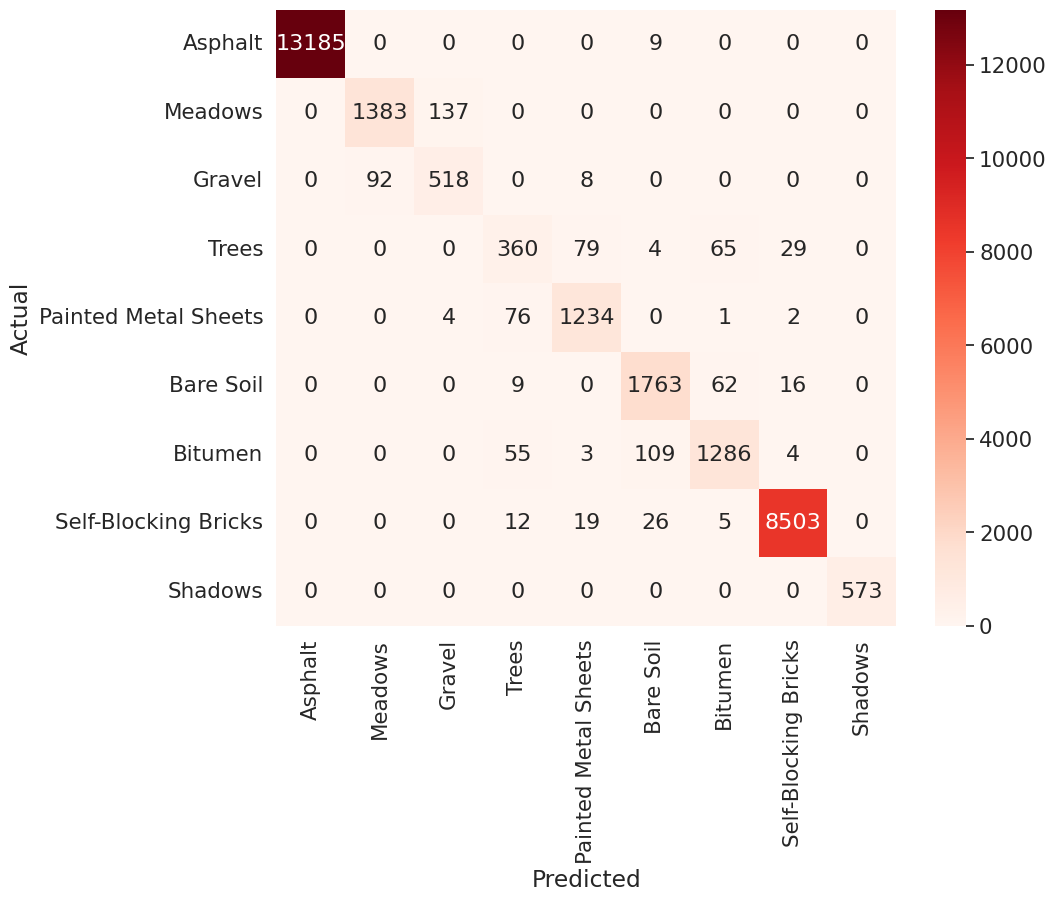

0.9457595954952884
                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00     13194
             Meadows       0.94      0.91      0.92      1520
              Gravel       0.79      0.84      0.81       618
               Trees       0.70      0.67      0.69       537
Painted Metal Sheets       0.92      0.94      0.93      1317
           Bare Soil       0.92      0.95      0.94      1850
             Bitumen       0.91      0.88      0.89      1457
Self-Blocking Bricks       0.99      0.99      0.99      8565
             Shadows       1.00      1.00      1.00       573

            accuracy                           0.97     29631
           macro avg       0.91      0.91      0.91     29631
        weighted avg       0.97      0.97      0.97     29631

f1 score accuracy is: 


TypeError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluation(global_y_test, ypred)

In [ ]:
df.columns

Index(['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8',
       'band9', 'band10',
       ...
       'band95', 'band96', 'band97', 'band98', 'band99', 'band100', 'band101',
       'band102', 'class', 'band1_dup'],
      dtype='object', length=104)

svm.fit has ran
check 3
Confusion Matrix: 
[[ 908    7   13    0    0    6    1   60    0]
 [   1 2765    0   28    0    3    0    1    0]
 [  66    0   16    0    0    0    0  233    0]
 [   0   92    0  368    0    0    0    0    0]
 [   0    0    0    0  202    0    0    0    0]
 [   1  610    0    0    0  138    0    5    0]
 [ 192    0    1    0    0    0    0    6    0]
 [  15    9    1    0    0    0    0  527    0]
 [   0    0    0    0    0    0    0    0  142]]


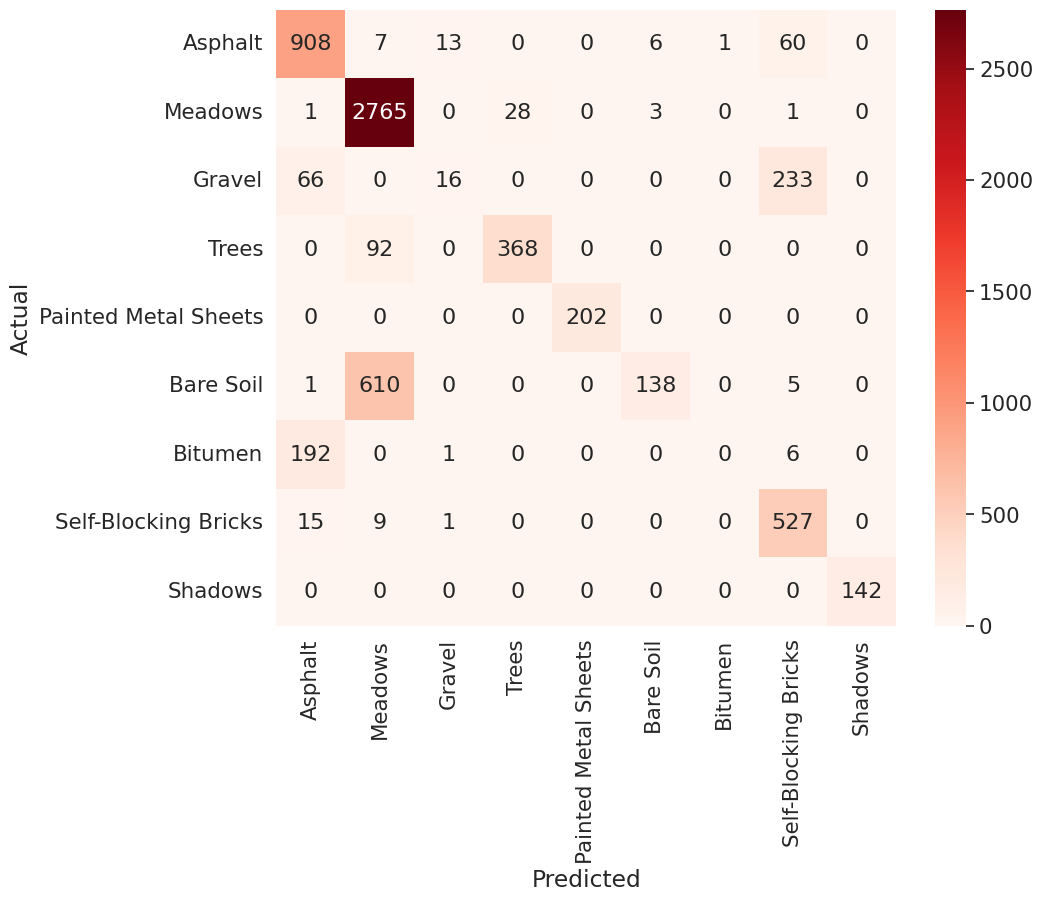

0.65216271884655
                      precision    recall  f1-score   support

             Asphalt       0.77      0.91      0.83       995
             Meadows       0.79      0.99      0.88      2798
              Gravel       0.52      0.05      0.09       315
               Trees       0.93      0.80      0.86       460
Painted Metal Sheets       1.00      1.00      1.00       202
           Bare Soil       0.94      0.18      0.31       754
             Bitumen       0.00      0.00      0.00       199
Self-Blocking Bricks       0.63      0.95      0.76       552
             Shadows       1.00      1.00      1.00       142

            accuracy                           0.79      6417
           macro avg       0.73      0.65      0.64      6417
        weighted avg       0.78      0.79      0.73      6417



<Figure size 640x480 with 0 Axes>

In [ ]:
svm, X_train, X_test, Y_train, Y_test = SVM(encoded_train, y_train, c= 1)
ypred = svm.predict(X_test)
evaluation(Y_test, ypred)
# save_results("ShallowAE_BMM_CWScores", "ShallowAE_BMM_CM", y_test, ypred)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
pca = PCA(n_components=3)
pca_result = pca.fit_transform(encoded_train)
print(pca.explained_variance_ratio_)

[0.75699282 0.1598518  0.04623331]


In [ ]:
y_train.shape

(32082,)

In [ ]:
encoded_train.shape

(32082, 40)

<ipython-input-38-f26e27a2b463>:8: UserWarning: 
The palette list has fewer values (8) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='pca-one', ylabel='pca-two'>

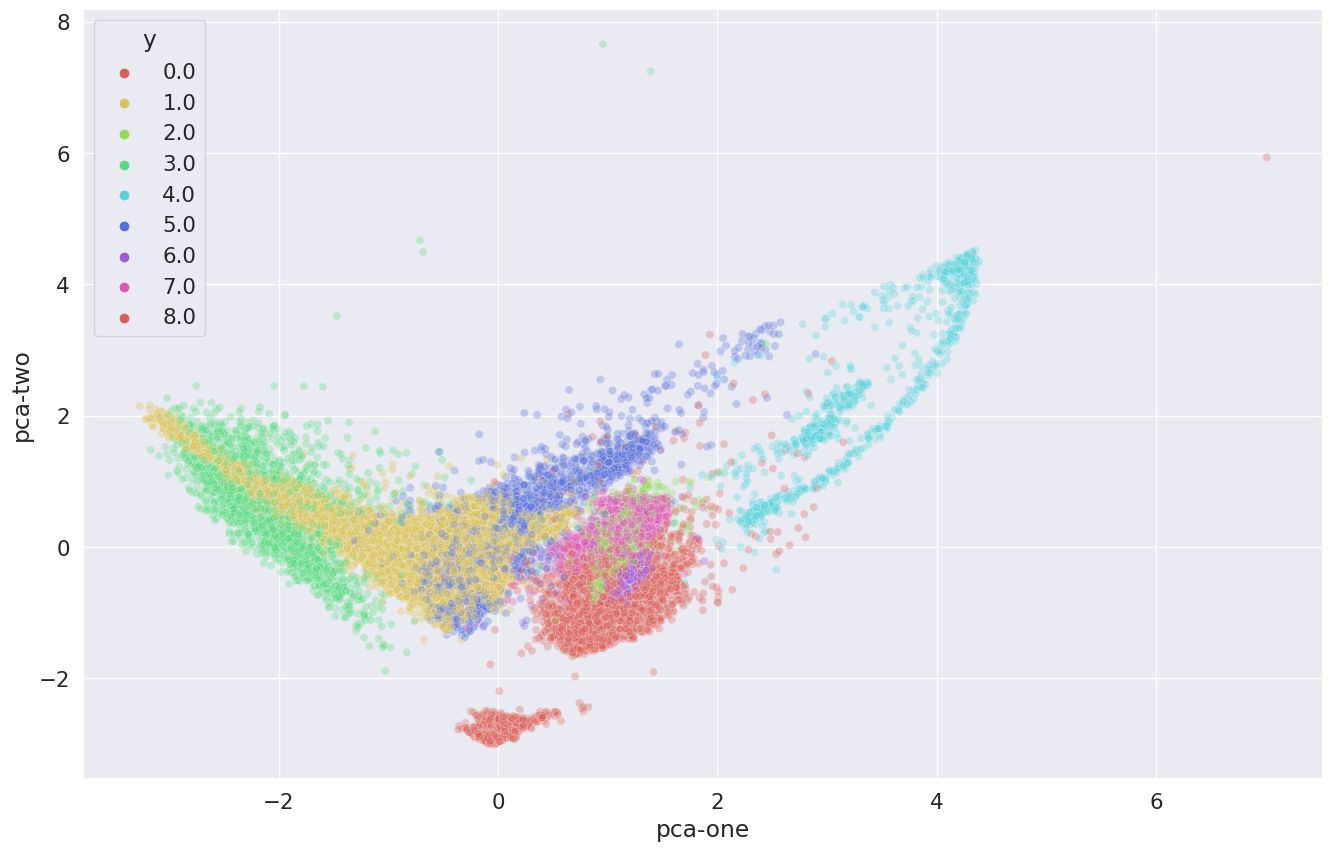

In [ ]:
f = pd.DataFrame()
f['pca-one'] = pca_result[:,0]
f['pca-two'] = pca_result[:,1]
f['pca-three'] = pca_result[:,2]

f['y'] = y_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 8),
    data=f,
    legend="full",
    alpha=0.3
)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8556 samples in 0.001s...
[t-SNE] Computed neighbors for 8556 samples in 0.950s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8556
[t-SNE] Computed conditional probabilities for sample 2000 / 8556
[t-SNE] Computed conditional probabilities for sample 3000 / 8556
[t-SNE] Computed conditional probabilities for sample 4000 / 8556
[t-SNE] Computed conditional probabilities for sample 5000 / 8556
[t-SNE] Computed conditional probabilities for sample 6000 / 8556
[t-SNE] Computed conditional probabilities for sample 7000 / 8556
[t-SNE] Computed conditional probabilities for sample 8000 / 8556
[t-SNE] Computed conditional probabilities for sample 8556 / 8556
[t-SNE] Mean sigma: 0.061458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.566315
[t-SNE] KL divergence after 300 iterations: 2.147132


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

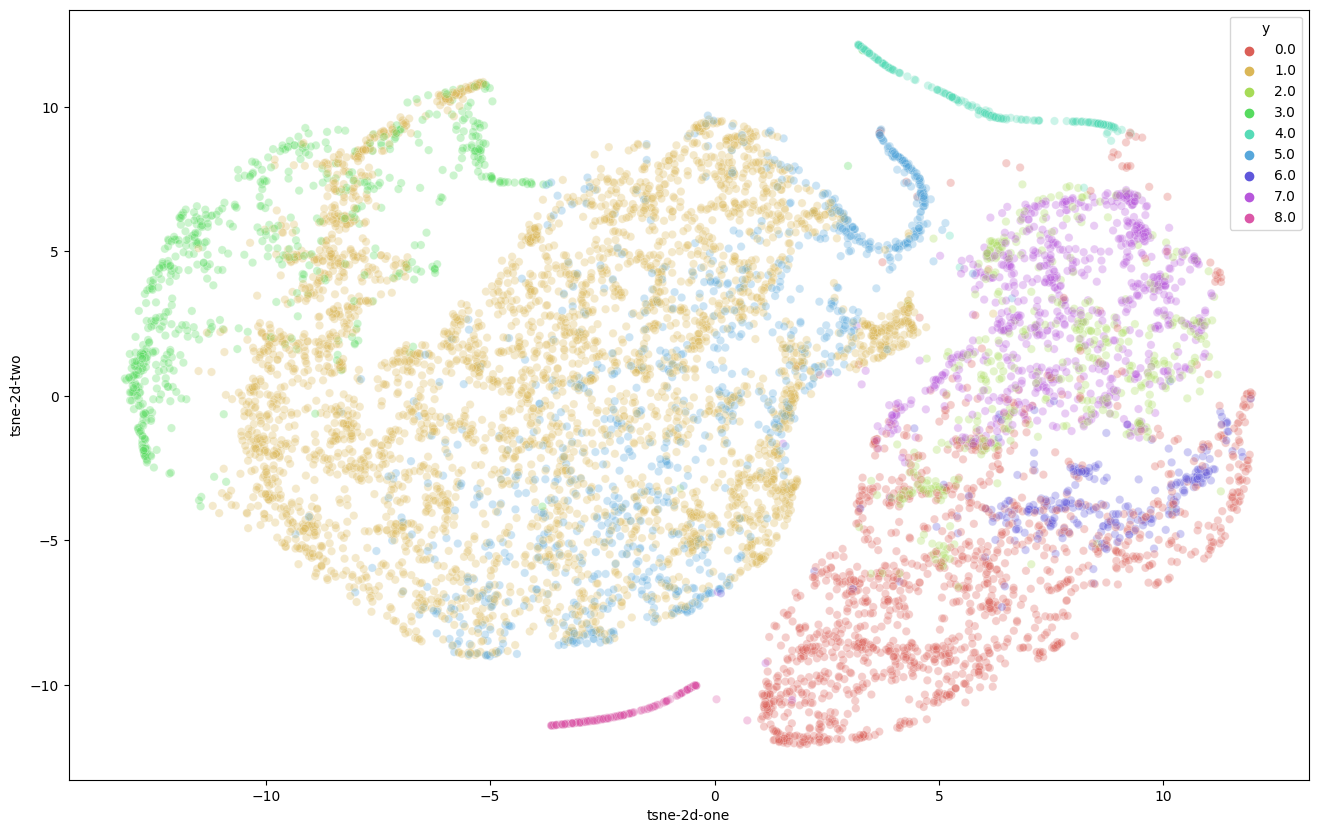

In [ ]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encoded_train)
tf = pd.DataFrame()
tf['tsne-2d-one'] = tsne_results[:,0]
tf['tsne-2d-two'] = tsne_results[:,1]
tf['y'] = global_y_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 9),
    data=tf,
    legend="full",
    alpha=0.3
)

<ipython-input-47-3bd1f7239141>:4: UserWarning: 
The palette list has fewer values (8) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

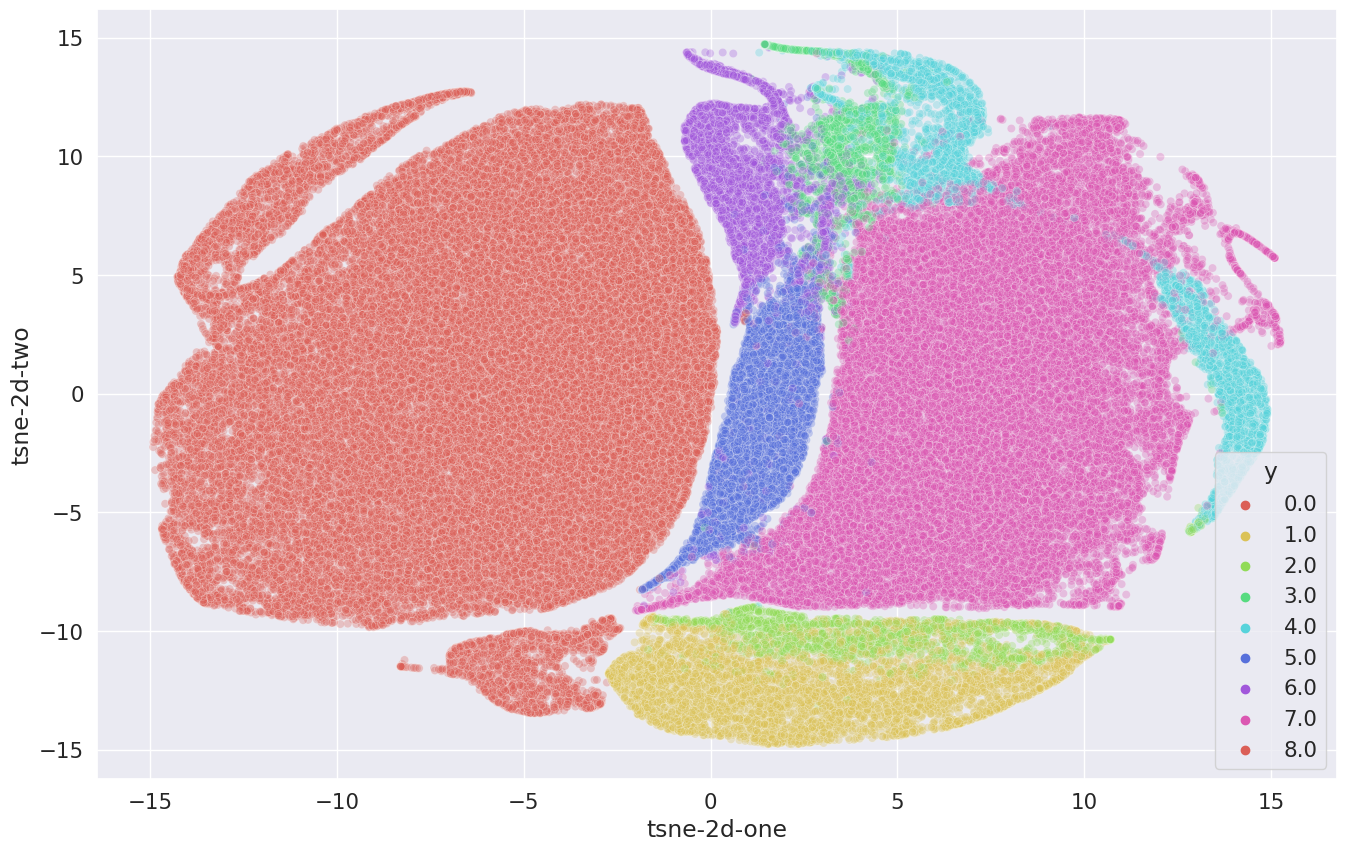

In [ ]:
tf['y'] = global_y_train

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 9),
    data=tf,
    legend="full",
    alpha=0.3
)

In [ ]:
df.to_csv("PUnormalisedData.csv")


In [ ]:
df['class'] = df['class']-1
df['class'].unique()

array([0, 3, 1, 7, 4, 8, 5, 2, 6], dtype=uint8)

Confusion Matrix: 
[[1228   10   15    1    0    8    0   64    0]
 [   1 3695    0   33    0    1    0    0    0]
 [  84    3   34    0    0    1    0  298    0]
 [   0  106    0  507    0    0    0    0    0]
 [   1    0    0    0  268    0    0    0    0]
 [   1  812    0    0    0  188    0    5    0]
 [ 256    0    1    0    0    0    0    9    0]
 [  20   10    8    0    1    3    0  695    0]
 [   0    0    0    0    0    0    0    0  189]]


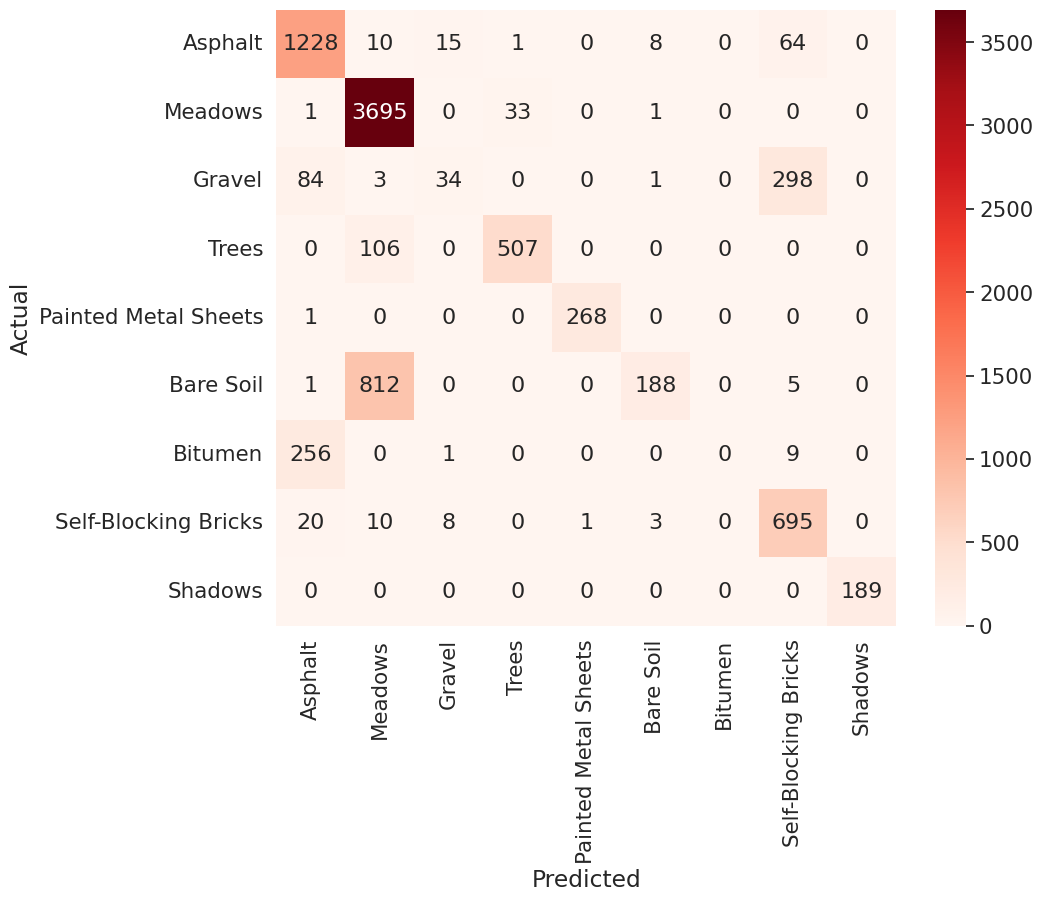

0.660069848661234
                      precision    recall  f1-score   support

             Asphalt       0.77      0.93      0.84      1326
             Meadows       0.80      0.99      0.88      3730
              Gravel       0.59      0.08      0.14       420
               Trees       0.94      0.83      0.88       613
Painted Metal Sheets       1.00      1.00      1.00       269
           Bare Soil       0.94      0.19      0.31      1006
             Bitumen       0.00      0.00      0.00       266
Self-Blocking Bricks       0.65      0.94      0.77       737
             Shadows       1.00      1.00      1.00       189

            accuracy                           0.80      8556
           macro avg       0.74      0.66      0.65      8556
        weighted avg       0.78      0.80      0.74      8556



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluation(y_test, ypred)
save_results("ShallowAE_BMM_CWScores", "ShallowAE_BMM_CM", y_test, ypred)

In [ ]:
q_norm

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-32,PC-33,PC-34,PC-35,PC-36,PC-37,PC-38,PC-39,PC-40,class
0,0.056065,0.912358,0.396031,0.0,0.820011,0.023658,0.861897,0.0,0.311140,0.0,...,0.0,0.828347,0.0,0.0,0.0,0.0,0.765253,0.021760,0.0,0.0
1,0.080689,0.870226,0.299519,0.0,0.733462,0.029773,0.786588,0.0,0.296502,0.0,...,0.0,0.786104,0.0,0.0,0.0,0.0,0.809162,0.025463,0.0,0.0
2,0.087436,0.877695,0.248405,0.0,0.719898,0.037586,0.781665,0.0,0.297830,0.0,...,0.0,0.757315,0.0,0.0,0.0,0.0,0.818741,0.012750,0.0,0.0
3,0.081574,0.879542,0.307223,0.0,0.764198,0.024579,0.818315,0.0,0.303625,0.0,...,0.0,0.780285,0.0,0.0,0.0,0.0,0.783954,0.011032,0.0,0.0
4,0.089364,0.856132,0.273318,0.0,0.721431,0.029212,0.762394,0.0,0.291234,0.0,...,0.0,0.778554,0.0,0.0,0.0,0.0,0.806640,0.019974,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,0.156524,0.762019,0.230540,0.0,0.590657,0.071325,0.566153,0.0,0.287794,0.0,...,0.0,0.685752,0.0,0.0,0.0,0.0,0.768956,0.050083,0.0,0.0
207396,0.150803,0.764544,0.242071,0.0,0.588919,0.073168,0.562277,0.0,0.286157,0.0,...,0.0,0.685804,0.0,0.0,0.0,0.0,0.760549,0.053554,0.0,0.0
207397,0.138773,0.773841,0.266743,0.0,0.616658,0.062215,0.592412,0.0,0.285629,0.0,...,0.0,0.734225,0.0,0.0,0.0,0.0,0.773431,0.053207,0.0,0.0
207398,0.137529,0.774330,0.254187,0.0,0.601873,0.062919,0.581951,0.0,0.283929,0.0,...,0.0,0.720766,0.0,0.0,0.0,0.0,0.773246,0.057209,0.0,0.0


(34220, 40) (34220,)
(8556, 40) (8556,)
svm.fit has ran
check 3
Confusion Matrix: 
[[1217   12    0    1    0    8    0   88    0]
 [   0 3694    0   35    0    1    0    0    0]
 [  93    3    0    0    0    0    0  324    0]
 [   0  158    0  455    0    0    0    0    0]
 [   0    0    0    0  269    0    0    0    0]
 [   1  830    0    0    1  172    0    2    0]
 [ 257    0    0    0    0    0    0    9    0]
 [  18   12    0    0    0    5    0  702    0]
 [   1    0    0    0    0    0    0    0  188]]


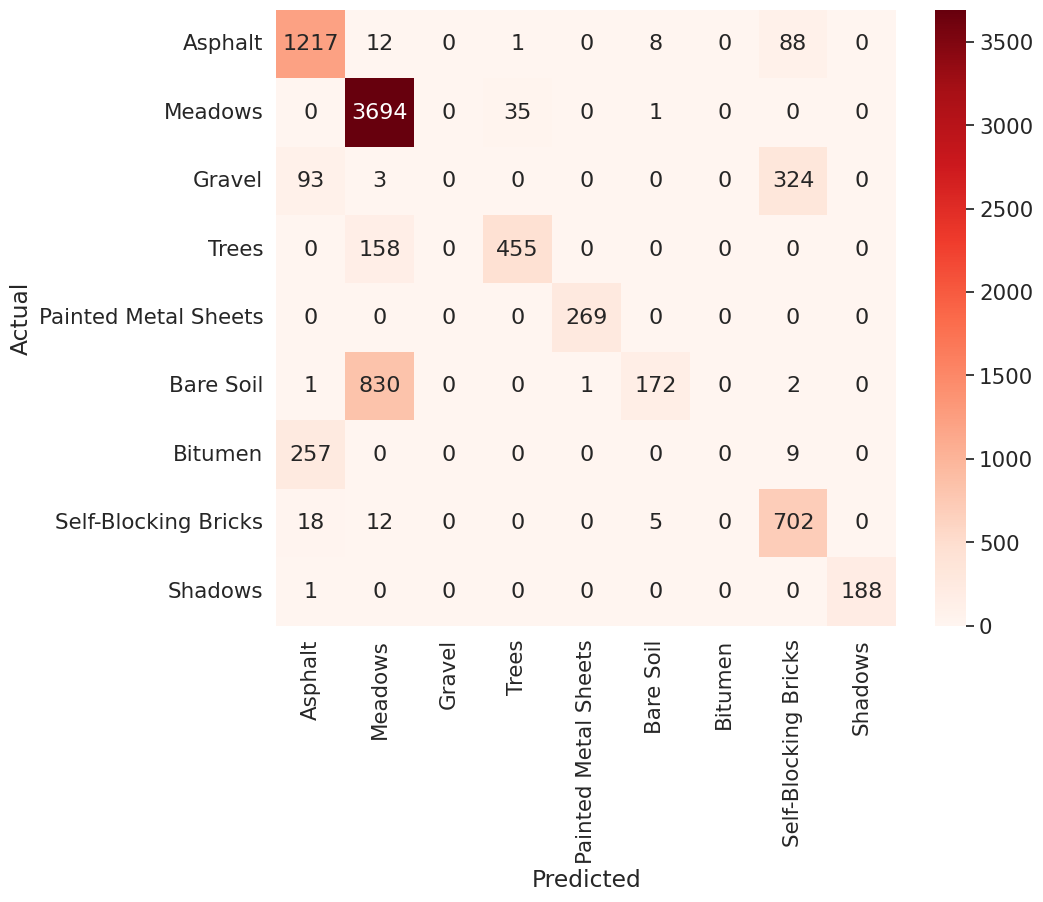

0.643014882381181
                      precision    recall  f1-score   support

             Asphalt       0.77      0.92      0.84      1326
             Meadows       0.78      0.99      0.88      3730
              Gravel       0.00      0.00      0.00       420
               Trees       0.93      0.74      0.82       613
Painted Metal Sheets       1.00      1.00      1.00       269
           Bare Soil       0.92      0.17      0.29      1006
             Bitumen       0.00      0.00      0.00       266
Self-Blocking Bricks       0.62      0.95      0.75       737
             Shadows       1.00      0.99      1.00       189

            accuracy                           0.78      8556
           macro avg       0.67      0.64      0.62      8556
        weighted avg       0.74      0.78      0.72      8556



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<Figure size 640x480 with 0 Axes>

In [ ]:
  svm, X_train, X_test, y_train, y_test = SVM(q, 0.2)
  ypred = svm.predict(X_test)
  evaluation(y_test, ypred)
  save_results("ShallowAE_BMM_CWScores", "ShallowAE_BMM_CM", y_test, ypred)

In [ ]:
#X=normalizeData(q.iloc[:, :-1], "sklearn")
#X = pd.concat([pd.DataFrame(data = X), pd.DataFrame(data = q.iloc[:, -1].ravel())], axis = 1)
#X.columns = [f'PC-{i}' for i in range(1,41)]+['class']
#svm, X_train, X_test, y_train, y_test = SVM(X)
#ypred = svm.predict(X_test)
#evaluation(y_test, ypred)
#save_results("ShallowAE_BMM_CWScores", "ShallowAE_BMM_CM", y_test, ypred)

In [ ]:
X.iloc[:, -1].value_counts()

AttributeError: ignored

In [ ]:
df.max()

In [ ]:
x=q
X = x.iloc[:, :-1].values
y = x.loc[:, 'class'].values
y_pred = svm.predict(X)
evaluation(y, y_pred)

In [ ]:
arr1 = y_pred.reshape(610,340)

In [ ]:
arr1.shape

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(y.reshape(610,340), cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(y_pred.reshape(610,340), cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

In [ ]:
df.columns = ['ypred']

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

In [ ]:
np.unique(ypred)

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

In [ ]:
y_train.shape

In [ ]:
print("\nSHALLOW AUTOENCODER\n")
X,y = ReadData()
df = ConvertDatasetIntoCSV(X,y)
q = AE_Shallow_Training(df, "band_min_max")
svm, X_train, X_test, y_train, y_test = SVM(q)
ypred = svm.predict(X_test)
save_results("ShallowAE_BMM_CWScores", "ShallowAE_BMM_CM", y_test, ypred)

## CNN 1D

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Activation, BatchNormalization, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical as keras_to_categorical
import tensorflow.keras
#names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows','10','11','12','13','14','15','16']
names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
datasetName = 'PaviaU'
matData = "paviaU"
X,y = ReadData(matFileName=datasetName, matData = matData)
#X = loadmat("Salinas"+'.mat')["salinas_corrected"]
#y = loadmat("Salinas" + '_gt.mat')["salinas" + '_gt']
df = ConvertDatasetIntoCSV(X,y)
df = normalizeData(df, "band_min_max")#normalizeData(df, "band_min_max")
df = df[df['class'] != 0]
df['class'] = df['class']-1
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)

def get_model_compiled(bands, num_class):
    clf = Sequential()
    clf.add(Conv1D(20, (24), activation='relu', input_shape=(bands,1)))
    clf.add(MaxPooling1D(pool_size=5))
    clf.add(Flatten())
    clf.add(Dense(100))
    clf.add(BatchNormalization())
    clf.add(Activation('relu'))
    clf.add(Dense(num_class, activation='softmax'))
    clf.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    return clf
# datasetName = 'PaviaS'
tensorflow.keras.backend.clear_session()
percentages = [100.00]#[0.10,0.25, 0.50, 0.75]#0.99, 100.00, 0.10, 0.25, 0.50, 0.75, 0.99]
Limited_Size_Experiments = pd.DataFrame(columns=["Dataset Name", "Train size percentage", "Overall F1 score", "Weighted average F1 Score", "IoU/Jaccard Score", "Kappa"])
metrics = [[],[],[],[]]
for i in percentages:
  print("Train size percentage: ", i)
  metrics = [[],[],[],[]]
  for iterations in range(5):
    print("Iteration number: ", iterations)
    if i!=100.00:
        lim_x_train, lim_x_test, lim_y_train, lim_y_test = train_test_split(global_x_train, global_y_train, test_size= 1 - i, random_state=20, stratify=global_y_train, shuffle=True)
            #lim_x_train = np.expand_dims(lim_x_train,axis=1)
        with tf.device(device):
          model = get_model_compiled(len(global_x_train[0]), len(np.unique(Y)))
          model.fit(lim_x_train, keras_to_categorical(lim_y_train, len(np.unique(lim_y_train))),
                          epochs=50,
                          batch_size=256,
                          #validation_split = 0.2,
                          shuffle=True)

    else:
      print('100 percent train data')
      with tf.device(device):
        model = get_model_compiled(len(global_x_train[0]), len(np.unique(Y)))
        model.fit(global_x_train, keras_to_categorical(global_y_train, len(np.unique(Y))),
                        epochs=50,
                        batch_size=256,
                        #validation_split = 0.2,
                        shuffle=True)
    y_pred = model.predict(global_x_test)
    ypred = []
    for j in y_pred:
      ypred.append(np.argmax(j))

    # Recording experiment results
    y_test = global_y_test
    overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']
    weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']
    Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")
    Kappa_Score = cohen_kappa_score(y_test, ypred)

    metrics[0].append(overall_f1_score)
    metrics[1].append(weighted_avg_f1_score)
    metrics[2].append(Jaccard_Score)
    metrics[3].append(Kappa_Score)
  print('metrics: ', metrics)
  new_row = {'Dataset Name':datasetName,
              'Train size percentage': i,
              'Overall F1 score': sum(metrics[0])/len(metrics[0]),
              'Weighted average F1 Score': sum(metrics[1])/len(metrics[1]),
              'IoU/Jaccard Score': sum(metrics[2])/len(metrics[2]),
              'Kappa': sum(metrics[3])/len(metrics[3])}
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)

print(Limited_Size_Experiments)# with sklearn minmax normalisation
Limited_Size_Experiments.to_csv("PaviaU_BMM_CNN.csv")


In [ ]:
Limited_Size_Experiments

,Dataset Name,Train size percentage,Overall F1 score,Weighted average F1 Score,IoU/Jaccard Score,Kappa
0,PaviaU,100.0,0.939434,0.936473,0.886001,0.919022


In [ ]:
df.to_csv("salinas_ready.csv")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Activation, BatchNormalization, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical as keras_to_categorical
import tensorflow.keras
import numpy as np
names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows','10','11','12','13','14','15','16']
#names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
datasetName = 'PaviaU'
matData = "paviaU"
X,y = ReadData(matFileName=datasetName, matData = matData)
df = ConvertDatasetIntoCSV(X,y)
df = normalizeData(df, "sklearn")#normalizeData(df, "band_min_max")
df = df[df['class'] != 0]
df['class'] = df['class']-1
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]
print(np.unique(Y, return_counts=True))
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)
print(np.unique(global_y_train, return_counts=True))


sklearn normalization
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([ 6631, 18649,  2099,  3064,  1345,  5029,  1330,  3682,   947]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([ 5305, 14919,  1679,  2451,  1076,  4023,  1064,  2945,   758]))


<ipython-input-22-f691232d953a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class']-1


In [ ]:
df.shape

(207400, 104)

In [ ]:
names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']
weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']
Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")
Kappa_Score = cohen_kappa_score(y_test, ypred)

new_row = {'Overall F1 score': overall_f1_score,
          'Weighted average F1 Score': weighted_avg_f1_score,
          'IoU/Jaccard Score': Jaccard_Score,
          'Kappa': Kappa_Score}

new_row #after band minmax norma

{'Overall F1 score': 0.9894704869899767,
 'Weighted average F1 Score': 0.9894854966058325,
 'IoU/Jaccard Score': 0.9791604047690612,
 'Kappa': 0.9850897019979324}

## Random Forest Classification

In [ ]:
#names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows','10','11','12','13','14','15','16']
names = ['Asphalt', 'Meadows','Gravel', 'Trees', 'Painted Metal Sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
datasetName = 'Pavia'
matData = "pavia"
X,y = ReadData(matFileName=datasetName, matData = matData)
df = ConvertDatasetIntoCSV(X,y)
df = normalizeData(df, "band_min_max")#normalizeData(df, "band_min_max")
df = df[df['class'] != 0]
df['class'] = df['class']-1
dX= df.values
X = dX[:,:-1]
Y = dX[:,-1]
global_x_train, global_x_test, global_y_train, global_y_test = train_test_split(X, Y, test_size=0.20, random_state=20, stratify=Y, shuffle=True)

percentages = [0.10, 0.25, 0.50, 0.75, 100.00]#0.99, 100.00, 0.10, 0.25, 0.50, 0.75, 0.99]
Limited_Size_Experiments = pd.DataFrame(columns=["Dataset Name", "Train size percentage", "Overall F1 score", "Weighted average F1 Score", "IoU/Jaccard Score", "Kappa"])
#metrics = [[],[],[],[]]
for i in percentages:
  print("Train size percentage: ", i)
  #metrics = [[],[],[],[]]
  if i!=100.00:
      lim_x_train, lim_x_test, lim_y_train, lim_y_test = train_test_split(global_x_train, global_y_train, test_size= 1 - i, random_state=20, stratify=global_y_train, shuffle=True)
      with tf.device(device):
        model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
        model.fit(lim_x_train, lim_y_train)
        #model.save('SalinasA_RF_'+str(i)+'.h5')

  else:
    print('100 percent train data')
    with tf.device(device):
      model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
      model.fit(global_x_train, global_y_train)
  ypred = model.predict(global_x_test)


    # Recording experiment results
  y_test = global_y_test
  overall_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['accuracy']*100
  weighted_avg_f1_score = classification_report(y_test, ypred, target_names = names, output_dict=True)['weighted avg']['f1-score']*100
  Jaccard_Score = jaccard_score(y_test, ypred, average= "micro")*100
  Kappa_Score = cohen_kappa_score(y_test, ypred)*100


  new_row = {'Dataset Name':datasetName,
              'Train size percentage': i,
              'Overall F1 score': overall_f1_score,
              'Weighted average F1 Score': weighted_avg_f1_score,
              'IoU/Jaccard Score': Jaccard_Score,
              'Kappa': Kappa_Score}
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)

#print(Limited_Size_Experiments)# with sklearn minmax normalisation
Limited_Size_Experiments.to_csv("PaviaC_BMM_RFC.csv")
Limited_Size_Experiments

<ipython-input-6-1a17c7f4b8e5>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized = (df.iloc[:, :-1] - min_values[np.newaxis, :])/(max_values[np.newaxis, :] - min_values[np.newaxis, :])


band_min_max normalization


<ipython-input-21-be61ae7a0ab4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class']-1


Train size percentage:  0.1


<ipython-input-21-be61ae7a0ab4>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  0.25


<ipython-input-21-be61ae7a0ab4>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  0.5


<ipython-input-21-be61ae7a0ab4>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  0.75


<ipython-input-21-be61ae7a0ab4>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


Train size percentage:  100.0
100 percent train data


<ipython-input-21-be61ae7a0ab4>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Limited_Size_Experiments = Limited_Size_Experiments.append(new_row, ignore_index=True)


,Dataset Name,Train size percentage,Overall F1 score,Weighted average F1 Score,IoU/Jaccard Score,Kappa
0,Pavia,0.10,97.944720,97.955594,95.972222,97.090098
1,Pavia,0.25,98.241706,98.254768,96.544176,97.510986
2,Pavia,0.50,98.545442,98.558493,97.132593,97.941148
3,Pavia,0.75,98.704060,98.711786,97.441279,98.165483
4,Pavia,100.00,98.693935,98.706794,97.421547,98.151425
